In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import cv2
import os
import glob
import random
from torch.utils.data import DataLoader
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from src import utils
from src import plots
from src import transforms
from src import validation
from src import loaddata
from src import loss
from src import metric
from src import unet256_3x3
from src.classifier import NucleiClassifier

In [2]:
TRAIN_DIR = "/home/ubuntu/bima/unet/data/train/"
TEST_DIR = "/home/ubuntu/bima/unet/data/test/"
FIXED_TRAIN_DIR = "/home/ubuntu/bima/unet/data/train_fixed/"
CLASS_DISTB_DIR = "/home/ubuntu/bima/unet/data/classes.csv"
DUMMY = "/home/ubuntu/bima/unet/data/dummy/"

In [3]:
test_ids = os.listdir(TEST_DIR)
print(len(test_ids))
dummy_ids = os.listdir(DUMMY)
print(len(dummy_ids))

65
13


In [4]:
image_dirs, image_masks, image_ids = utils.image_mask_paths(FIXED_TRAIN_DIR)

In [5]:
class_distb = pd.read_csv(CLASS_DISTB_DIR)

In [6]:
class_distb.head()

,filename,foreground,background,is_train
0,d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...,white,black,True
1,4596961c789d3b41916492918797724fe75128239fefc5...,white,black,True
2,b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...,white,black,True
3,831218e6a1a54b23d4be56c5799854e7eb978811b89215...,white,black,True
4,b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...,white,black,True


In [7]:
pd.pivot_table(class_distb, index=['is_train', 'background', 'foreground'], aggfunc='count')

filename
is_train background foreground          
False    black      white             53
         purple     purple             1
         white      purple             3
         yellow     purple             8
True     black      white            546
         purple     purple            70
         white      black             16
                    purple            38

In [8]:
class_distb[~class_distb.is_train].groupby(['foreground', 'background']).count().reset_index()

,foreground,background,filename,is_train
0,purple,purple,1,1
1,purple,white,3,3
2,purple,yellow,8,8
3,white,black,53,53


In [9]:
train_ids, valid_ids = validation.get_stratified_valid_dirs(class_distb)

In [10]:
image_p = "{0}{1}/images/{1}.png".format(FIXED_TRAIN_DIR, train_ids[1])
mclass_p = "{}{}/multiclass_mask.png".format(FIXED_TRAIN_DIR, train_ids[1])
assert os.path.isfile(image_p)
assert os.path.isfile(mclass_p)
image = utils.open_image(image_p)

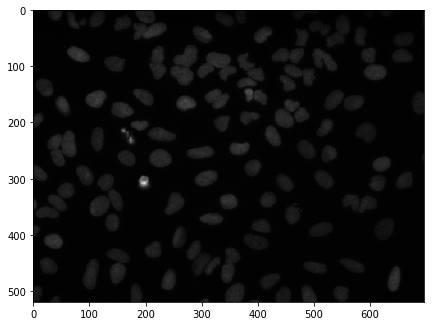

In [11]:
plots.show_with_size(image)

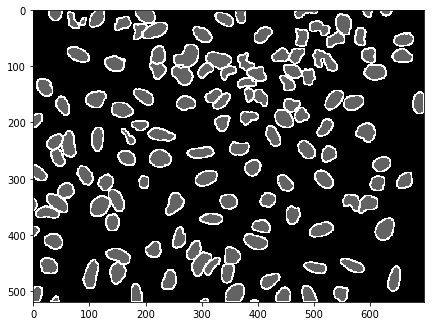

In [12]:
mclass_mask = utils.read2D(mclass_p)
plots.show_with_size(mclass_mask)

In [13]:
ims = [val == mclass_mask for val in np.unique(mclass_mask)]

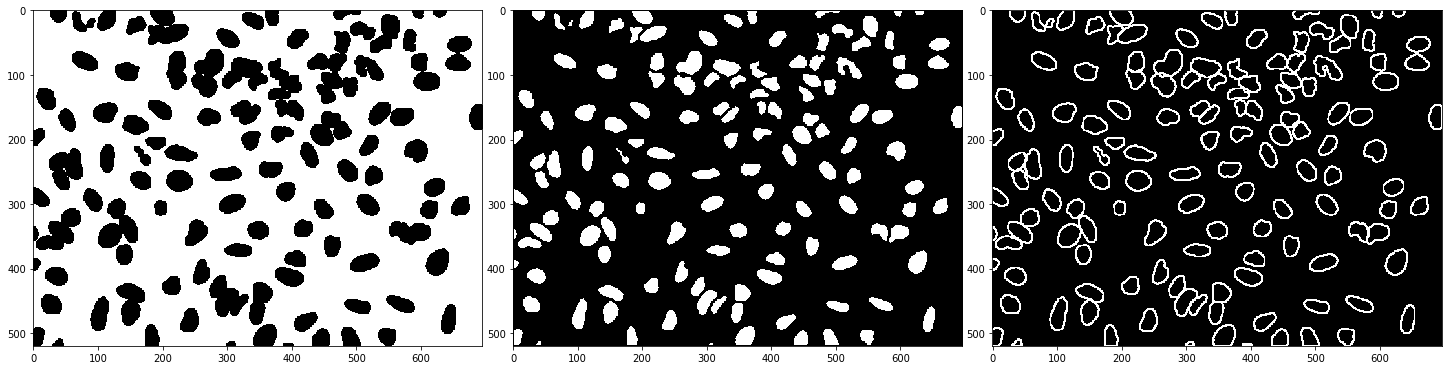

In [14]:
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(1, 3, 1)
plt.imshow(ims[0], cmap='gray')
fig.add_subplot(1, 3, 2)
plt.imshow(ims[1], cmap='gray')
fig.add_subplot(1, 3, 3)
plt.imshow(ims[2], cmap='gray')
plt.tight_layout(pad=0.1)

In [15]:
image = transforms.random_horizontal_flip_transform(image)
image = transforms.fix_resize_transform(image, 256, 256)

In [16]:
train_data = loaddata.ImageLoader(FIXED_TRAIN_DIR, train_ids, mode='train', transform=transforms.train_augment)
train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
valid_data = loaddata.ImageLoader(FIXED_TRAIN_DIR, valid_ids, mode='valid', transform=transforms.train_augment)
valid_dl = DataLoader(valid_data, batch_size=32, shuffle=True)
test_data = loaddata.ImageLoader(TEST_DIR, test_ids, mode='test', transform=transforms.test_augment)
test_dl = DataLoader(test_data, batch_size=1, shuffle=False)
dummy_data = loaddata.ImageLoader(DUMMY, dummy_ids, mode='train', transform=transforms.train_augment)
dummy_dl = DataLoader(dummy_data, batch_size=1, shuffle=True)

In [17]:
train, target, id_= train_data[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


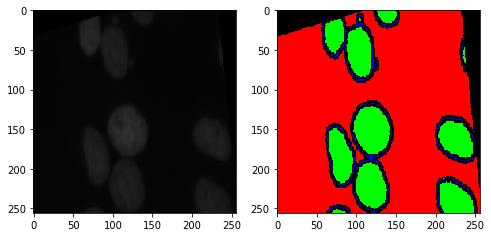

In [18]:
plots.plot_pair_from_arr(train.data.cpu().numpy().transpose(1,2,0)*255,target.data.cpu().numpy().transpose(1,2,0)*255)

In [19]:
in_shape = (3,256,256)
classes = 3
net = unet256_3x3.UNet256_3x3(in_shape, classes).cuda()
criteria = loss.MulticlassBCELoss2d()
metric_ = metric.dice_score
optimizer = optim.RMSprop(net.parameters(), lr=0.1)

In [20]:
classifier = NucleiClassifier(net, criteria, metric_, optimizer, gpu=0)

In [1]:
classifier.train(dummy_dl, valid_dl, 100, "models/3classTargetBseline.pth")

NameError: name 'classifier' is not defined

In [42]:
p = FIXED_TRAIN_DIR + "00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/masks/"
mask_paths = glob.glob(p + '/*')
mc_mask = np.sum(np.array([utils.multiclass_mask(item) for item in mask_paths]),0)
out = np.clip(mc_mask, 0, 2)

In [43]:
np.unique(out)

array([0, 1, 2])

In [44]:
out[np.where(out == 0)] = 30
out[np.where(out == 1)] = 110
out[np.where(out == 2)] = 215

In [45]:
plt.imsave("here.png", out)

In [46]:
utils.make_multiclass_mask(p, always=True, mcm_name='temp.png')

In [47]:
img = cv2.imread("here.png", cv2.IMREAD_GRAYSCALE)

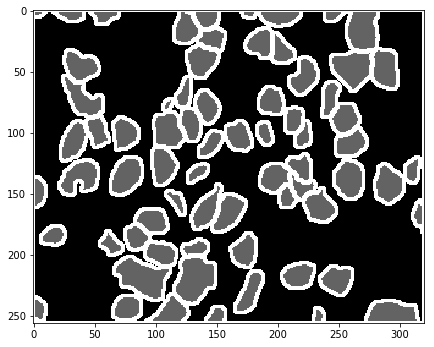

In [48]:
plots.show_with_size(img)

In [49]:
np.unique(img)

array([ 30, 102, 215], dtype=uint8)

In [50]:
img3d = transforms.get_3d_mask(img)

In [51]:
np.unique(img3d)

array([0, 1])

In [52]:
back_channel = (img == 30)*1
nuclei_channel = (img == 102)*1
contour_channel = (img == 215)*1

In [53]:
np.unique(back_channel)

array([0, 1])

In [54]:
img_out = np.dstack([back_channel, nuclei_channel, contour_channel]).astype(np.uint8)

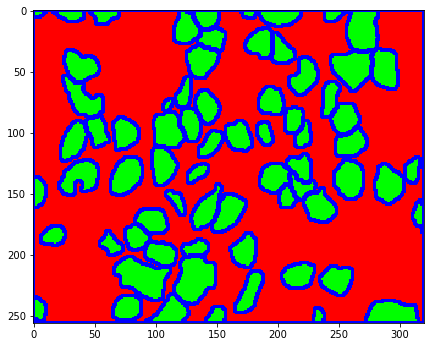

In [55]:
plots.show_with_size(img_out*255)

In [65]:
img_, img_out_r = transforms.fix_resize_transform2(img, img_out, 256,256)

In [68]:
np.unique(img_out_r)

array([0], dtype=uint8)